Notebook purpose

- Understand role of spend distribution for savings behaviour


Does distribution of spends across categories capture anything useful about a person's behviour?

Two dimensions:

- Distribution at a given point in time (Shannon entropy)

- Distribution over time (Jensen-Shannon divergence)


Assumptions:

1. More chaotic life correlates with more chaotic spending correlates with probability of making savings transfer.
2. Entropy scores, based on number of categories spent on, captures chaoticness of spending.

We find that entropy is significantly related to financial behaviour, but that the way in which we calculate entropy matters greatly:
- If we apply Laplace smoothing to counts, entropy is negatively correlated with savings as expected.
- If we don't, it's positively correlated.

We need to understand why that is.

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

Helpers

In [65]:
import functools

regplot = functools.partial(
    sns.regplot,
    data=dfa,
    scatter_kws=dict(alpha=0.1, edgecolor="white"),
    line_kws=dict(color="orange", linestyle="dashed"),
    lowess=True,
)


def regplot_entropy_on_x(x, **kwargs):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    for i, m in enumerate(["tag", "tag_auto", "merchant"]):
        regplot(x=x, y=f"entropy_{m}", ax=ax[0, i], **kwargs)
        regplot(x=x, y=f"entropy_{m}_s", ax=ax[1, i], **kwargs)

## Data

In [2]:
df = hd.read_txn_data("X77")
dfa = hd.read_analysis_data("X77")
dfs = hd.read_txn_data("777")

Time for read_txn_data                 : 28.63 seconds
Time for read_analysis_data            : 0.55 seconds
Time for read_txn_data                 : 1.51 seconds


In [3]:
# tmp fixes
dfa = dfa.rename(columns={"id": "has_od_fees"})

Defind index of user-months for series subsetting

In [4]:
dfa_user_months = dfa.set_index(["user_id", "date"]).index

Add counts

In [5]:
def counts(df, cat):
    """User-month txn counts by spend catetory."""
    group_cols = idx_cols + [cat]
    return (
        df.loc[df.tag_group.eq("spend") & df.debit]
        .groupby(group_cols, observed=True)
        .size()
        .unstack()
        .fillna(0)
        .rename(columns=lambda x: "count_" + x)
    )


s = counts(df, "tag").reset_index()
dfa = dfa.merge(s, how="left", validate="1:1")

Case study generator

In [6]:
def random_user_data(df, cols="count"):
    """Return counts for random user.

    Args:
    df: Analysis df with spend tag category counts.
    cols: Group of columns from {count, spend}.
    """
    user = np.random.choice(df.user_id.unique())
    return df[df.user_id.eq(user)].filter(regex=f"^{cols}")


random_user_data(dfa).head(10)

,count_communication,count_services,count_household,count_finance,count_other_spend,count_retail,count_motor,count_travel,count_hobbies
3050,2.0,20.0,11.0,2.0,9.0,5.0,1.0,3.0,0.0
3051,2.0,26.0,12.0,3.0,5.0,6.0,4.0,2.0,0.0
3052,2.0,11.0,7.0,3.0,5.0,2.0,2.0,0.0,0.0
3053,2.0,8.0,7.0,3.0,6.0,1.0,2.0,0.0,0.0
3054,2.0,7.0,8.0,3.0,9.0,1.0,0.0,3.0,0.0
3055,2.0,11.0,17.0,3.0,7.0,5.0,2.0,2.0,0.0
3056,2.0,17.0,12.0,3.0,5.0,2.0,3.0,0.0,0.0
3057,2.0,8.0,5.0,3.0,7.0,1.0,0.0,1.0,1.0
3058,2.0,12.0,10.0,3.0,8.0,8.0,3.0,4.0,1.0
3059,2.0,14.0,14.0,3.0,10.0,1.0,2.0,3.0,1.0


In [7]:
random_user_data(dfa, cols="spend").head(10)

,spend_communication,spend_services,spend_household,spend_finance,spend_other_spend,spend_retail,spend_motor,spend_travel,spend_hobbies
7432,0.00000,0.28865,1.69834,0.09228,0.14198,0.095290,0.04717,0.000000,0.03000
7433,0.04760,1.11235,1.75050,0.09212,0.08000,0.303560,0.10428,0.221610,0.01000
7434,0.02420,0.45692,1.63438,0.09224,0.30294,1.009857,0.08937,0.086570,0.01000
7435,0.02081,0.83221,1.75840,0.09244,0.08482,0.350610,0.08858,0.000000,0.02240
7436,0.05850,0.42681,1.69333,0.09212,0.25000,0.104820,0.04389,0.000000,0.01000
7437,0.01400,1.22177,1.63657,0.10411,0.07254,0.281420,0.08210,0.000000,0.01000
7438,0.07591,0.44412,1.61860,0.09227,0.08099,0.181980,0.00000,0.526350,0.01495
7439,0.04430,1.46648,1.78928,0.11346,0.29443,0.216550,0.09740,2.137235,0.04650
7440,0.06425,0.51557,1.70188,0.14380,0.20850,0.297220,0.09052,0.000000,0.01000
7441,0.01400,0.44320,1.79171,0.55108,0.24555,0.072090,0.09485,0.000000,0.08922


## Relationship between smoothed and unsmoothd entropy

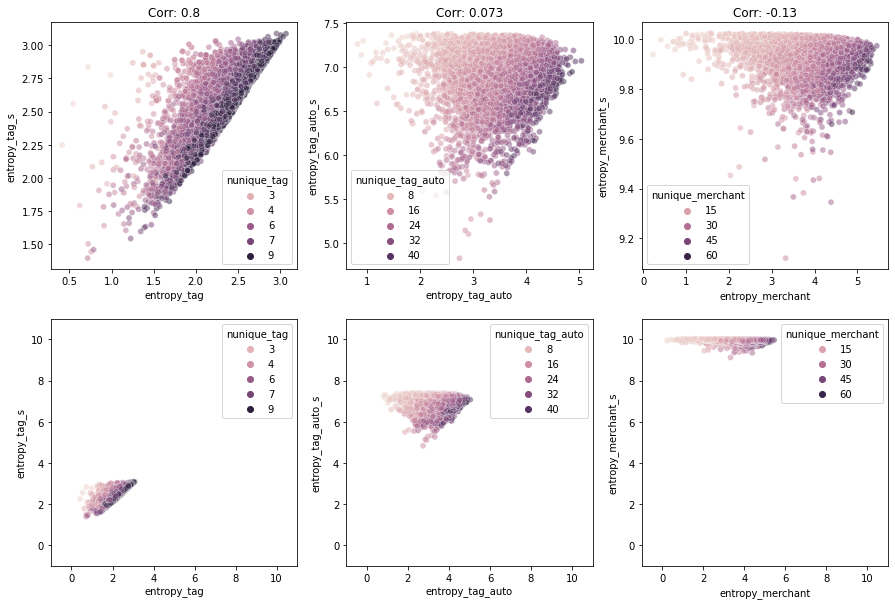

In [402]:
import functools

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    y = f"entropy_{m}_s"
    x = f"entropy_{m}"
    hue = f"nunique_{m}"
    data = dfa
    alpha = 0.5

    scatter = functools.partial(
        sns.scatterplot, x=x, y=y, hue=hue, data=data, alpha=alpha
    )
    scatter(ax=ax[0, i]).set(title=f"Corr: {data[x].corr(data[y]):.2}")
    scatter(ax=ax[1, i]).set(xlim=(-1, 11), ylim=(-1, 11))

For more on relationshiop between the two, see `entropy_calculation.ipynb`. Basically, smoothing turns (user-month spend) distributions with many zero counts from low entropy to high entropy scores. Hence, the more distributions with a large number of zero scores there are, the higher the impact of smoothing, and the lower the relationship between smoothed and unsmoothed scores. The three different categorical variables shown are increasing in their number of unique categories, and hence in the number of possible (and actual) zeroes. As a result, the correlation weakens as we move from left to right.

## Understanding unsmoothed entropy

Seems to mainly capture the number of distinct categories a user spends money on

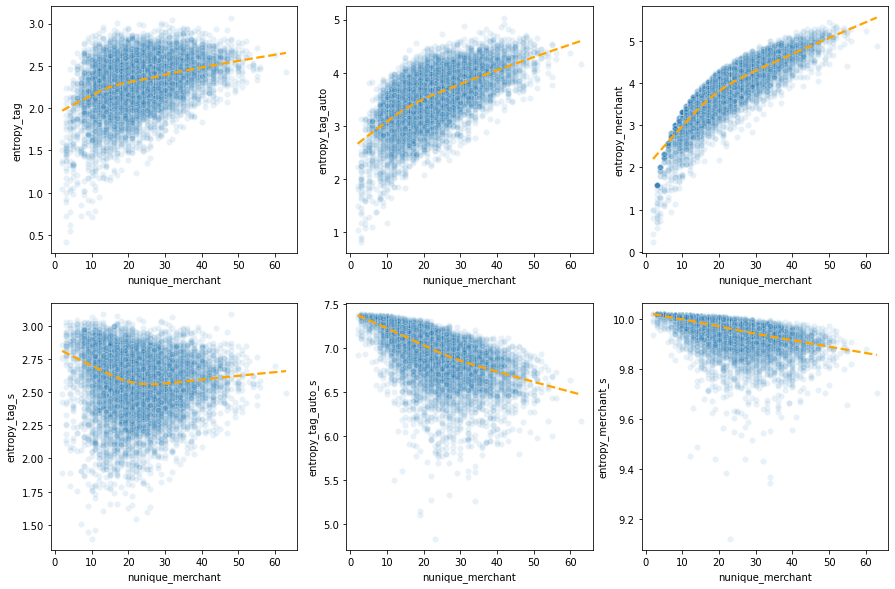

In [66]:
regplot_entropy_on_x(x=f"nunique_{m}")

## Understanding smoothed entropy

Seems to mainly capture the total number of txns and the difference in category counts (they are very closely correlated).

### Standard deviations

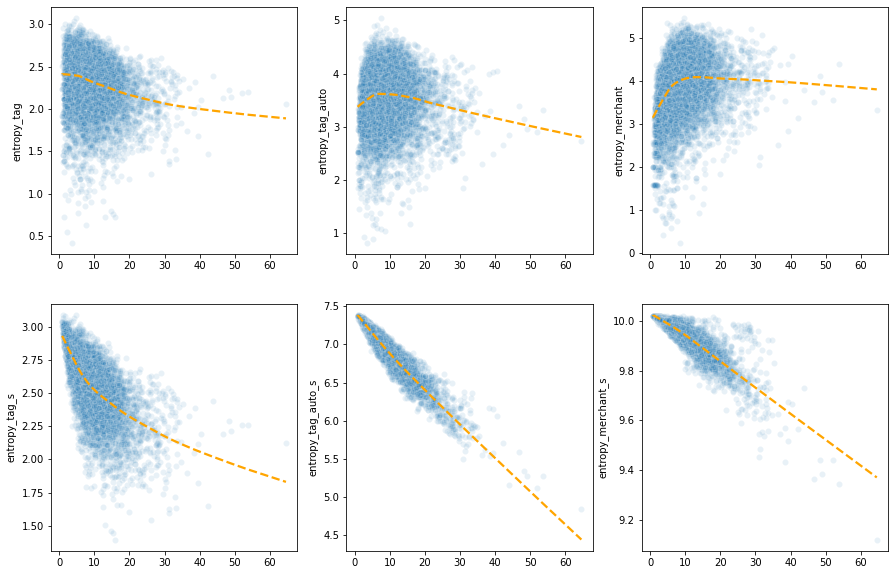

In [67]:
def count_std(df):
    return dfa.filter(regex="^count").std(1)


stds = count_std(dfa)
regplot_entropy_on_x(x=stds)

### Number of txns

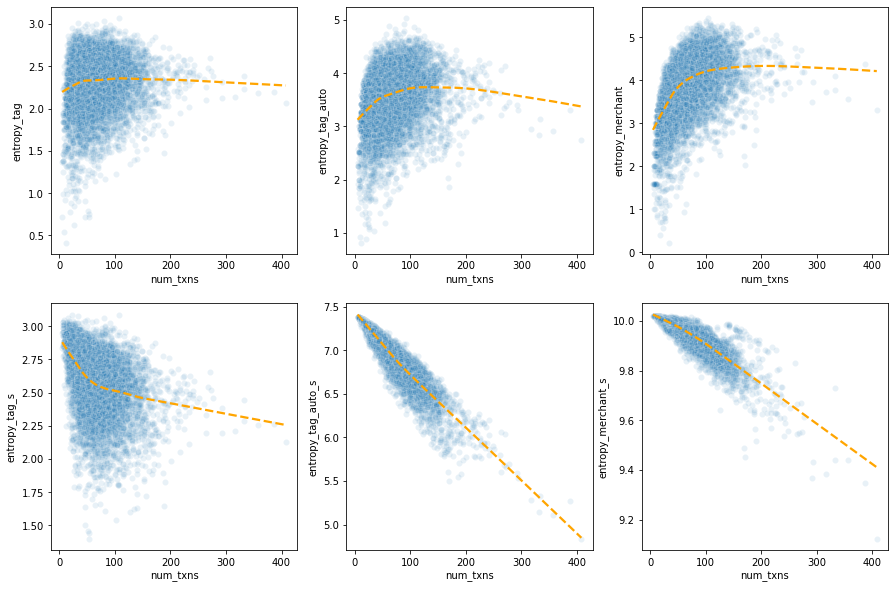

In [68]:
def calc_num_txns(df):
    return df.sum(1).rename("num_txns")


num_txns = calc_num_txns(dfa.filter(regex="^count"))

regplot_entropy_on_x(x=num_txns)

- As we'd expect, the two measures correlate strongly, since a high std requires a large number of txns, and the variance of std for a given txn count increases with the txn count.

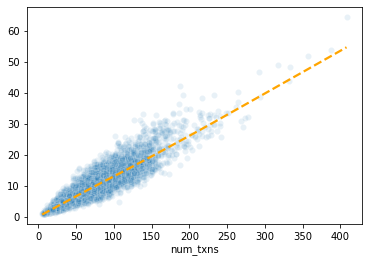

In [69]:
regplot(
    y=stds,
    x=num_txns,
);